In [1]:
def extraer_informacion(url, archivo_csv):
    #Importamos librerias
    import requests
    from bs4 import BeautifulSoup
    import urllib.parse
    import csv

    # Crea una lista para almacenar los enlaces
    link_list = []

    # Establece un límite para el número de páginas a procesar
    limit = 500

    # Establece el offset inicial
    of = 0

    while of<limit:
        # Realiza una solicitud HTTP a la página web con el offset actual
        response = requests.get(f"{url}/recent-submissions?offset={of}")

        # Obtiene el HTML de la respuesta
        html = response.text

        # Crea un objeto BeautifulSoup a partir del HTML
        soup = BeautifulSoup(html, "html.parser")
        
        # Parsea la URL
        parsed_url = urllib.parse.urlparse("{}/recent-submissions?offset={}".format(url, of))
        # Obtiene el contenido principal de la URL (todo antes del /repositorio)
        url_base = parsed_url.scheme + '://' + parsed_url.netloc

        # Busca todos los enlaces <a> en el HTML con clase image-link 
        # Esto permite buscar los hrefs que estan ligados a las imagenes(thumbnails) de cada tesis
        # Solo funciona si el repositorio usa thumbnails
        links = soup.find_all("a",{"class":"image-link"})
        hrefs1 = [url_base + a["href"] for a in links]

        # Itera sobre cada enlace y agrega su atributo "href" a la lista
        for link in hrefs1:
            link_list.append(link)

        # Incrementa el offset para la siguiente iteración
        of += 20

    # Acesso a la tabla de metadatos añadiendo ?show=full
    links_full = [link + '?show=full' for link in link_list]

    # Abre un archivo CSV en modo escritura
    with open(archivo_csv, 'w', newline='') as csvfile:
        # Crea el objeto escritor
        writer = csv.writer(csvfile)
        # Escribe la cabecera del archivo CSV
        writer.writerow(['Autores', 'Asesores', 'Título', 'Resumen', 'Año', 'Institución', 'Grado'])

        # Recorre cada link
        for link in links_full:
            # Descarga el contenido del link
            html = requests.get(link).text
            # Parsea el contenido del link
            soup = BeautifulSoup(html, 'html.parser')

            # Obtiene la información de cada link
            
            # Autores: como pueden ser varios se usa un bucle for
            authors = [element['content'] for element in soup.find_all('meta', {'name': 'citation_author'})]
            
            # Asesores y Grado: se usa find_next_sibling porque existe un problema de identificación con la etiqueta "td"
            asesores = [element.find_next_sibling().text for element in soup.find_all('td', string='dc.contributor.advisor')]
            grado = [element.find_next_sibling().text for element in soup.find_all('td', string='thesis.degree.name')]
            
            # Titulo, Resumen, Año e Institución: cuando la etiqueta es "meta" es más fácil de encontrar
            titulo = soup.find('meta', {'name': 'citation_title'})['content']
            abstract = soup.find('meta', {'name': "DCTERMS.abstract"})['content']
            año = soup.find('meta', {'name': "citation_date"})['content']
            institucion = soup.find('meta', {'name': 'citation_publisher'})['content']
            

            # Escribe la fila en el archivo CSV
            writer.writerow([authors, asesores, titulo, abstract, año, institucion, grado])

In [46]:
#extraemos 3 csv de los 3 repositorios
extraer_informacion("https://repositorio.esan.edu.pe/handle/20.500.12640/1814", "esan_repo.csv")

In [ ]:
extraer_informacion("https://tesis.pucp.edu.pe/repositorio/handle/20.500.12404/757", "pucp_repo.csv")

In [47]:
extraer_informacion("https://repositorioacademico.upc.edu.pe/handle/10757/621395", "upc_repo.csv")

In [ ]:
# Información estadistica importante

In [61]:

import pandas as pd

# Leemos los datasets
esan_df = pd.read_csv("esan_repo.csv")
pucp_df = pd.read_csv("pucp_repo.csv")
upc_df = pd.read_csv("upc_repo.csv")

# Concatenamos los dataframes en uno solo
df = pd.concat([esan_df, pucp_df, upc_df])

# Reseteamos los indexes para evitar errores
df = df.reset_index()


In [62]:
# Contamos la cantidad de tesis por institución
tesis_por_institucion = df["Institución"].value_counts()

print(tesis_por_institucion)

Universidad Peruana de Ciencias Aplicadas (UPC)    395
Universidad ESAN                                    89
Pontificia Universidad Católica del Perú            61
Name: Institución, dtype: int64


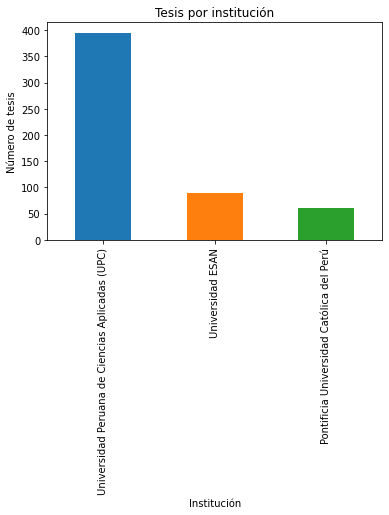

In [63]:
import matplotlib.pyplot as plt

#Graficamos la cantidad de tesis por institución

# Dibujamos el gráfico de barras
tesis_por_institucion.plot.bar(
    # Usamos colores especificos para cada barra
    color=["#1f77b4", "#ff7f0e", "#2ca02c"],
    # Añadimos un título al gráfico
    title="Tesis por institución",
    # Añadimos un título a cada eje
    xlabel="Institución",
    ylabel="Número de tesis",
)

# Mostramos el gráfico
plt.show()

In [64]:
# Las variables de interés son: Años, Autores y Asesores

# Referente a Años

# Convertimos la columna "año" a tipo datetime
df["Año"] = pd.to_datetime(df["Año"], utc=True)

# Seleccionamos solo el año con la propiedad dt.year
df["Año"] = df["Año"].dt.year

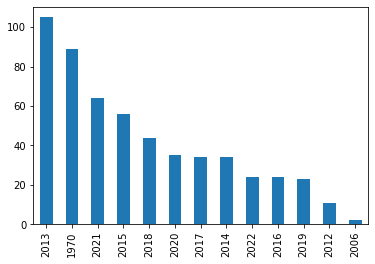

In [65]:
# Gráfico general de tesis por año

# Contamos la cantidad de tesis por año
tesis_por_año = df["Año"].value_counts()

# Graficamos la cantidad de tesis por año
tesis_por_año.plot.bar()
plt.show()

In [66]:
# Ahora podemos calcular el promedio de tesis por año
promedio_tesis_por_año = tesis_por_año.mean()

# Mostramos el resultado
print(f"Promedio de tesis por año: {promedio_tesis_por_año:.2f}")

Promedio de tesis por año: 41.92


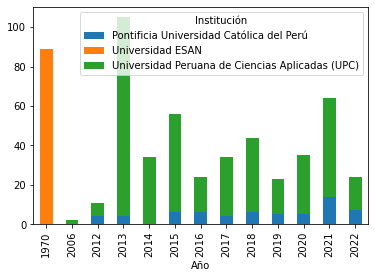

In [67]:
# Gráfico de tesis por año, diferenciando la institución

# Contamos la cantidad de tesis por año y por institución
tesis_por_año_e_institucion = df.groupby(["Año", "Institución"]).size().reset_index(name="Cantidad")

# Creamos un dataframe con la cantidad de tesis por año y por institución
df_tesis = pd.pivot_table(tesis_por_año_e_institucion, index="Año", columns="Institución", values="Cantidad", fill_value=0)

# Graficamos el dataframe como un gráfico de barras apiladas
df_tesis.plot.bar(stacked=True)


plt.show()


In [68]:
# Agrupamos el DataFrame por institución y contamos la cantidad de tesis por año
tesis_por_institucion = df.groupby(["Institución", "Año"])["Año"].count()

# Iteramos sobre cada institución y obtenemos el año donde se publicó la mayor cantidad de tesis
for institucion, tesis_por_año in tesis_por_institucion.groupby(level=0):
    # Obtenemos el año con la mayor cantidad de tesis
    año_con_mas_tesis = tesis_por_año.idxmax()[1]
    print(f"La institución {institucion} publicó la mayor cantidad de tesis en el año {año_con_mas_tesis}")

La institución Pontificia Universidad Católica del Perú publicó la mayor cantidad de tesis en el año 2021
La institución Universidad ESAN publicó la mayor cantidad de tesis en el año 1970
La institución Universidad Peruana de Ciencias Aplicadas (UPC) publicó la mayor cantidad de tesis en el año 2013


In [69]:
tesis_por_año_e_institucion.groupby('Institución').Cantidad.agg(['mean', 'std', 'nunique'])

,mean,std,nunique
Institución,,,
Pontificia Universidad Católica del Perú,6.100000,2.960856,5
Universidad ESAN,89.000000,NaN,1
Universidad Peruana de Ciencias Aplicadas (UPC),32.916667,26.265976,9


In [70]:
# Referente a Autores y Asesores

# Convertimos el formato de Autores y Asesores de string a list

import ast

df['Autores'] = df['Autores'].apply(lambda x: ast.literal_eval(x))

In [71]:
df['Asesores'] = df['Asesores'].apply(lambda x: ast.literal_eval(x))

In [72]:
# Separamos cada asesor de la lista en una fila independiente del dataframe
df_ase = df['Asesores'].apply(pd.Series).stack()
df_ase = df_ase.reset_index(level=1, drop=True)

# Contamos cuántos artículos ha ayudado a publicar cada asesor
asesores_por_articulo = df_ase.value_counts()

# Mostramos el asesor que ha contribuido a más artículos
print(asesores_por_articulo.head(6))

/tmp/ipykernel_5777/1145348155.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ase = df['Asesores'].apply(pd.Series).stack()


Subauste Oliden, Daniel Alejandro    95
Mendívil, Eduardo                    38
López, Samantha                      35
Yana Motta, Dafny Margoth            26
Armas Aguirre, Jimmy Alexander       26
Santana Ormeño, Martín               24
dtype: int64


In [73]:
# Separamos cada autor de la lista en una fila independiente del dataframe
df_au = df['Autores'].apply(pd.Series).stack()
df_au = df_au.reset_index(level=1, drop=True)

# Contamos cuántos artículos ha publicado cada autor
autores_por_articulo = df_au.value_counts()

# Mostramos el autor que ha publicado más artículos
print(autores_por_articulo.head(6))

Rojas Tello, Francisco Alexander     2
Galarreta Velarde, Anibal Antonio    2
Ingaruca Cruzado, Cesar Miguel       2
Masías Echeverría, Claudia Janet     2
Tarazona Lévano, Cynthia             1
Castañeda Reyes, Cinthya             1
dtype: int64


In [74]:
import pandas as pd

# Creamos una nueva columna con el número de autores de cada artículo
df['Numero de autores'] = df['Autores'].apply(lambda x: len(x))

# Contamos cuántos artículos hay con cada número de autores
numero_de_autores = df['Numero de autores'].value_counts()

# Calculamos la proporción de artículos con cada número de autores
proporcion_de_articulos = numero_de_autores / df.shape[0]

print(proporcion_de_articulos)

2    0.656881
1    0.196330
4    0.082569
5    0.040367
3    0.023853
Name: Numero de autores, dtype: float64


In [75]:
# Creamos una nueva columna con el número de autores de cada artículo
df['Numero de autores'] = df['Autores'].apply(lambda x: len(x))

# Calculamos la media de autores por artículo
media_de_autores = df['Numero de autores'].mean()

print(media_de_autores)


2.1137614678899084


In [76]:
# Creamos una nueva columna con el número de autores de cada artículo
df['Numero de asesores'] = df['Asesores'].apply(lambda x: len(x))

# Calculamos la media de autores por artículo
media_de_asesores = df['Numero de asesores'].mean()

print(media_de_asesores)

1.198165137614679
